# MILESTONE 1: TEXT SUMMARIZATION & PARAPHRASING
TextMorph: Compares T5, BART, and PEGASUS for summarization and paraphrasing, evaluating length and similarity, with visual charts to show performance.

# **STEP 1**: Install Libraries
In this section, we import all the Python libraries needed for summarization, paraphrasing, and evaluation tasks.

In [94]:
# Install libraries
!pip install transformers sentencepiece evaluate sentence-transformers matplotlib pandas --quiet


In [96]:
# Imports
from transformers import pipeline # Load NLP models
from sentence_transformers import SentenceTransformer  # Sentence embeddings
from sklearn.metrics.pairwise import cosine_similarity # Compare vectors
import requests, re, textwrap # Fetch & clean text

# **STEP 2**: Load Pre-trained Models
We load multiple models for both *summarization* and *paraphrasing*, including T5, BART, and PEGASUS.

In [97]:
# Load pipelines on CPU
summarizer_t5 = pipeline("summarization", model="t5-base", device=-1)
summarizer_bart = pipeline("summarization", model="facebook/bart-base", device=-1)
summarizer_pegasus = pipeline("summarization", model="google/pegasus-xsum", device=-1)
#These models generate concise summaries from longer texts.

paraphraser_t5 = pipeline("text2text-generation", model="Vamsi/T5_Paraphrase_Paws", device=-1)
paraphraser_bart = pipeline("text2text-generation", model="eugenesiow/bart-paraphrase", device=-1)
paraphraser_pegasus = pipeline("text2text-generation", model="tuner007/pegasus_paraphrase", device=-1)
#These models rephrase the text without changing its meaning.

similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Pipelines & similarity model loaded.")
#This model evaluates how similar the generated text is to the original text.

Device set to use cpu
Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Pipelines & similarity model loaded.


# **STEP 3**: Load Input Data
In this section, we load the text files that will be summarized and paraphrased.
We read multiple input files (e.g., File_1.txt, File_2.txt, etc.) from the local directory.

In [98]:
# Load and clean texts
urls = [
    "https://www.gutenberg.org/files/84/84-0.txt",
    "https://www.gutenberg.org/files/1342/1342-0.txt"
]
texts = [requests.get(url).text for url in urls]

def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_texts = [clean_text(txt)[:13000] for txt in texts]  # take first 13000 chars for CPU speed


# **STEP 4**: Text Summarization
In this section, we summarize each input file using three different models — T5, BART, and PEGASUS — and compare their results.



**STEP 4.1**: Text Summarization With T5

In [99]:
# Summarize large text with T5
def summarize_t5(text, chunk_size=500, max_len=150, min_len=40):
    summaries = []
    words = text.split()
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size])
        summary = summarizer_t5(chunk, max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']
        summaries.append(summary)
    return " ".join(summaries)

t5_summaries = [summarize_t5(txt) for txt in cleaned_texts]


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


**STEP 4.2**: Text Summarization With BART

In [11]:
#BART Summarization
def summarize_bart(text, chunk_size=500, max_len=150, min_len=40):
    summaries = []
    words = text.split()
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size])
        summary = summarizer_bart(chunk, max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']
        summaries.append(summary)
    return " ".join(summaries)

bart_summaries = [summarize_bart(txt) for txt in cleaned_texts]


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


**STEP 4.3**: Text Summarization With Pegasus-xsum

In [100]:
# PEGASUS-xsum Summarization

def summarize_pegasus_safe(text, max_len=60, min_len=20, chunk_words=150):
    """
    Summarize text safely on CPU using Pegasus-XSum.
    - chunk_words: number of words per chunk (keep small to avoid errors)
    """
    summaries = []
    words = text.split()

    for i in range(0, len(words), chunk_words):
        chunk = " ".join(words[i:i+chunk_words]).strip()
        if not chunk:
            continue
        try:
            result = summarizer_pegasus(chunk, max_length=max_len, min_length=min_len, do_sample=False)
            if result and 'summary_text' in result[0]:
                summaries.append(result[0]['summary_text'])
        except Exception as e:
            print(f"⚠️ Skipping chunk due to Pegasus error: {e}")
            continue

    return " ".join(summaries)

# Apply to cleaned texts
pegasus_summaries = [summarize_pegasus_safe(txt) for txt in cleaned_texts]
print("✅ Pegasus summarization done.")





✅ Pegasus summarization done.


# **STEP 5**: Text Paraphrasing
After summarization, we generate paraphrased versions using T5, BART, and PEGASUS models.



**STEP 5.1**: Text Paraphrasing With Pegasus-xsum

In [101]:
# PEGASUS Paraphrasing

def paraphrase_pegasus_safe_v2(text, max_tokens=60, num_return=1):
    """
    Safe Pegasus paraphrasing for CPU.
    - max_tokens: max tokens per chunk
    - num_return: number of paraphrases per chunk
    """
    paras = []
    try:
        # encode & truncate safely
        inputs = paraphraser_pegasus.tokenizer(
            text, return_tensors="pt", truncation=True, max_length=max_tokens
        )
        results = paraphraser_pegasus.model.generate(
            **inputs,
            max_length=max_tokens,
            num_return_sequences=num_return,
            do_sample=False,
            early_stopping=True
        )
        decoded = paraphraser_pegasus.tokenizer.batch_decode(results, skip_special_tokens=True)
        paras.extend(decoded)
    except Exception as e:
        print(f"⚠️ Skipping text due to error: {e}")

    return " ".join(paras)

# Apply to all cleaned texts
pegasus_paraphrases = [paraphrase_pegasus_safe_v2(txt) for txt in cleaned_texts]

print("✅ Pegasus Paraphrasing done.")










✅ Pegasus Paraphrasing done.


**STEP 5.2**: Text Paraphrasing With T5

In [102]:
# T5 Paraphrasing

def paraphrase_t5(text, chunk_size=300, num_return=2):
    paraphrases = []
    words = text.split()
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size]).strip()
        if not chunk:
            continue
        try:
            results = paraphraser_t5(chunk, num_return_sequences=num_return, do_sample=False)
            paraphrases.extend([r['generated_text'] for r in results])
        except Exception as e:
            print(f"⚠️ Skipping chunk due to error: {e}")
            continue
    return paraphrases

t5_paraphrases = [paraphrase_t5(summary) for summary in t5_summaries]

**STEP 5.3**: Text Paraphrasing With BART

In [104]:
# BART Paraphrasing

def paraphrase_bart(text, chunk_size=300, num_return=2):
    paraphrases = []
    words = text.split()
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size]).strip()
        if not chunk:
            continue
        try:
            results = paraphraser_bart(chunk, num_return_sequences=num_return, do_sample=False)
            paraphrases.extend([r['generated_text'] for r in results])
        except Exception as e:
            print(f"⚠️ Skipping chunk due to error: {e}")
            continue
    return paraphrases

bart_paraphrases = [paraphrase_bart(summary) for summary in bart_summaries]

# **STEP 6**: Model Comparison
It clearly indicates both summarization and paraphrasing metrics.

**STEP 6.1**: Similarity analysis

In [105]:
# Similarity Analysis

from sklearn.metrics.pairwise import cosine_similarity

# Function to compute similarity between two texts
def compute_similarity(text1, text2):
    embeddings = similarity_model.encode([text1, text2])
    sim_score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return sim_score

# Compute similarity between original text and summaries
summary_similarities = []
for i, orig_text in enumerate(cleaned_texts):
    t5_sim = compute_similarity(orig_text, t5_summaries[i])
    bart_sim = compute_similarity(orig_text, bart_summaries[i])
    pegasus_sim = compute_similarity(orig_text, pegasus_summaries[i])

    summary_similarities.append({
        'T5_vs_Original': t5_sim,
        'BART_vs_Original': bart_sim,
        'PEGASUS_vs_Original': pegasus_sim
    })

# Compute similarity between original text and paraphrases (average over all generated paraphrases)
paraphrase_similarities = []
for i, orig_text in enumerate(cleaned_texts):
    t5_paras_sim = sum([compute_similarity(orig_text, p) for p in t5_paraphrases[i]]) / len(t5_paraphrases[i])
    bart_paras_sim = sum([compute_similarity(orig_text, p) for p in bart_paraphrases[i]]) / len(bart_paraphrases[i])
    pegasus_paras_sim = sum([compute_similarity(orig_text, p) for p in pegasus_paraphrases[i]]) / len(pegasus_paraphrases[i])

    paraphrase_similarities.append({
        'T5_Paraphrases_vs_Original': t5_paras_sim,
        'BART_Paraphrases_vs_Original': bart_paras_sim,
        'PEGASUS_Paraphrases_vs_Original': pegasus_paras_sim
    })

# Display results
for i in range(len(cleaned_texts)):
    print(f"\n=== Text {i+1} Similarities ===")
    print("Summary Similarity to Original:")
    for k, v in summary_similarities[i].items():
        print(f"{k}: {v:.3f}")
    print("\nParaphrase Similarity to Original (Average):")
    for k, v in paraphrase_similarities[i].items():
        print(f"{k}: {v:.3f}")



=== Text 1 Similarities ===
Summary Similarity to Original:
T5_vs_Original: 0.365
BART_vs_Original: 0.999
PEGASUS_vs_Original: 0.634

Paraphrase Similarity to Original (Average):
T5_Paraphrases_vs_Original: 0.298
BART_Paraphrases_vs_Original: 0.424
PEGASUS_Paraphrases_vs_Original: 0.082

=== Text 2 Similarities ===
Summary Similarity to Original:
T5_vs_Original: 0.553
BART_vs_Original: 0.962
PEGASUS_vs_Original: 0.612

Paraphrase Similarity to Original (Average):
T5_Paraphrases_vs_Original: 0.391
BART_Paraphrases_vs_Original: 0.347
PEGASUS_Paraphrases_vs_Original: 0.045


**STEP 6.2**: Summary Length analysis

In [106]:
# Function to compute summary lengths
def summary_lengths(summaries):
    return [len(s.split()) for s in summaries]

t5_lengths = summary_lengths(t5_summaries)
bart_lengths = summary_lengths(bart_summaries)
pegasus_lengths = summary_lengths(pegasus_summaries)

# Example display
import pandas as pd
length_df = pd.DataFrame({
    'T5': t5_lengths,
    'BART': bart_lengths,
    'PEGASUS': pegasus_lengths
})
print(length_df)



    T5  BART  PEGASUS
0  274  1073      360
1  271   965      425


**STEP 6.3**: Paraphrasing Length analysis

In [107]:
# Function to compute paraphrase lengths
def paraphrase_lengths(paraphrases_list):
    lengths = []
    for paras in paraphrases_list:
        # Flatten nested lists if any
        if isinstance(paras, list):
            paras_flat = [p for sub in paras for p in (sub if isinstance(sub, list) else [sub])]
        else:
            paras_flat = [paras]
        # Take average length if multiple paraphrases per text
        if paras_flat:
            avg_len = sum(len(p.split()) for p in paras_flat) / len(paras_flat)
        else:
            avg_len = 0
        lengths.append(int(avg_len))
    return lengths

# Compute lengths for each model
t5_para_lengths = paraphrase_lengths(t5_paraphrases)
bart_para_lengths = paraphrase_lengths(bart_paraphrases)
pegasus_para_lengths = paraphrase_lengths(pegasus_paraphrases)

# Display in DataFrame
para_length_df = pd.DataFrame({
    'T5': t5_para_lengths,
    'BART': bart_para_lengths,
    'PEGASUS': pegasus_para_lengths
}, index=['0', '1'])  # Adjust index for your files

print(para_length_df)


   T5  BART  PEGASUS
0  69    92       25
1  76    70        8


**STEP 6.4**: Similarity to Original Calculation for Summarization

In [108]:
# Function to compute cosine similarity
def compute_similarity(original_texts, summaries):
    embeddings_orig = similarity_model.encode(original_texts, convert_to_tensor=True).cpu().numpy()
    embeddings_sum = similarity_model.encode(summaries, convert_to_tensor=True).cpu().numpy()
    sims = cosine_similarity(embeddings_orig, embeddings_sum)
    # Diagonal contains similarity of each summary to its own original text
    return [sims[i, i] for i in range(len(original_texts))]

# Apply to all summaries
t5_sim = compute_similarity(cleaned_texts, t5_summaries)
bart_sim = compute_similarity(cleaned_texts, bart_summaries)
pegasus_sim = compute_similarity(cleaned_texts, pegasus_summaries)

sim_df = pd.DataFrame({
    'T5': t5_sim,
    'BART': bart_sim,
    'PEGASUS': pegasus_sim
})
print(sim_df)



         T5      BART   PEGASUS
0  0.364638  0.998928  0.634017
1  0.552900  0.961536  0.611819


**STEP 6.5**: Similarity to Original Calculation for Paraphrasing

In [109]:
# Function to compute best similarity for paraphrases
def paraphrase_similarity(summaries, paraphrases_list):
    best_sims = []
    for orig, paras in zip(summaries, paraphrases_list):
        if not paras:
            best_sims.append(0.0)
            continue

        # Flatten nested lists if any
        if isinstance(paras[0], list):
            paras = [p for sub in paras for p in sub]

        try:
            # Encode and move to CPU numpy
            embeddings_orig = similarity_model.encode([orig], convert_to_tensor=True).cpu().numpy().reshape(1, -1)
            embeddings_paras = similarity_model.encode(paras, convert_to_tensor=True).cpu().numpy()
            if embeddings_paras.ndim == 1:
                embeddings_paras = embeddings_paras.reshape(1, -1)

            # Compute cosine similarities
            sims = cosine_similarity(embeddings_orig, embeddings_paras)
            best_sims.append(float(sims.max()))
        except Exception as e:
            print(f"⚠️ Skipping paraphrase due to error: {e}")
            best_sims.append(0.0)
            continue

    return best_sims

# Compute similarity for each model
t5_para_sim = paraphrase_similarity(t5_summaries, t5_paraphrases)
bart_para_sim = paraphrase_similarity(bart_summaries, bart_paraphrases)
pegasus_para_sim = paraphrase_similarity(pegasus_summaries, pegasus_paraphrases)

# Display in DataFrame
para_sim_df = pd.DataFrame({
    'T5': t5_para_sim,
    'BART': bart_para_sim,
    'PEGASUS': pegasus_para_sim
}, index=['0', '1'])  # Adjust index for your files

print(para_sim_df)


         T5      BART   PEGASUS
0  0.736641  0.730177  0.247895
1  0.794357  0.634907  0.279839


# **STEP 7**: Original Text vs Generated Text

**STEP 7.1**: Summarization with T5, BART and Pegasus Model

In [110]:
# Loop through files
for i, original in enumerate(cleaned_texts):
    print(f"\n--- File {i} ---\n")
    print("Original Text (first 500 chars):")
    print(original[:500], "\n")  # show first 500 chars for brevity

    print("T5 Summary:")
    print(t5_summaries[i], "\n")

    print("BART Summary:")
    print(bart_summaries[i], "\n")

    print("PEGASUS Summary:")
    print(pegasus_summaries[i], "\n")



--- File 0 ---

Original Text (first 500 chars):
*** START OF THE PROJECT GUTENBERG EBOOK 84 *** Frankenstein; or, the Modern Prometheus by Mary Wollstonecraft (Godwin) Shelley CONTENTS Letter 1 Letter 2 Letter 3 Letter 4 Chapter 1 Chapter 2 Chapter 3 Chapter 4 Chapter 5 Chapter 6 Chapter 7 Chapter 8 Chapter 9 Chapter 10 Chapter 11 Chapter 12 Chapter 13 Chapter 14 Chapter 15 Chapter 16 Chapter 17 Chapter 18 Chapter 19 Chapter 20 Chapter 21 Chapter 22 Chapter 23 Chapter 24 Letter 1 _To Mrs. Saville, England._ St. Petersburgh, Dec. 11th, 17 . Yo 

T5 Summary:
cnn's john sutter writes a letter to the editor of a new book . the author's first task is to assure her sister of her welfare and increasing confidence in the success of her undertaking . she writes: "i will satiate my ardent curiosity with the sight of an part of the world never before visited" elizabeth mccarthy was a seafarer on several expeditions to the north sea . she devoted her life to studying mathematics, the theory of m

**STEP 7.2**: Paraphrazing with T5, BART and Pegasus Model

In [111]:
# Loop through files
for i in range(len(cleaned_texts)):
    print(f"\n--- File {i} Paraphrases ---\n")

    print("T5 Paraphrases:")
    print(t5_paraphrases[i], "\n")

    print("BART Paraphrases:")
    print(bart_paraphrases[i], "\n")

    print("PEGASUS Paraphrases:")
    print(pegasus_paraphrases[i], "\n")



--- File 0 Paraphrases ---

T5 Paraphrases:
["cnn's john sutter writes a letter to the editor of a new book . elizabeth mccarthy was a seafarer on several expeditions to the north sea . she devoted her life to studying mathematics , the theory of medicine , and other branches of physical science . his lieutenant is a man of great courage and enterprise , he is madly desirous of glory , he writes . david rot", "cnn's john sutter writes a letter to the editor of a new book . elizabeth mccarthy was a seafarer on several expeditions to the north sea . she devoted her life to studying mathematics , the theory of medicine , and other branches of physical science . his lieutenant is a man of great courage and enterprise , he is madly desirous of glory . david rothkopf: i"] 

BART Paraphrases:
['*** START OF THE PROJECT GUTENBERG EBOOK 84 *** Frankenstein. I am already far north of London, and I feel my heart glow with an enthusiasm which elevates me to heaven, for nothing contributes so much

# **STEP 8**: Plots,Visualization & Insights
Bar charts are used to show comparison between models

**STEP 8.1**: Enhanced Summarization Metric Plots

   T5_length  BART_length  PEGASUS_length    T5_sim  BART_sim  PEGASUS_sim
0        274         1073             360  0.364638  0.998928     0.634017
1        271          965             425  0.552900  0.961536     0.611819


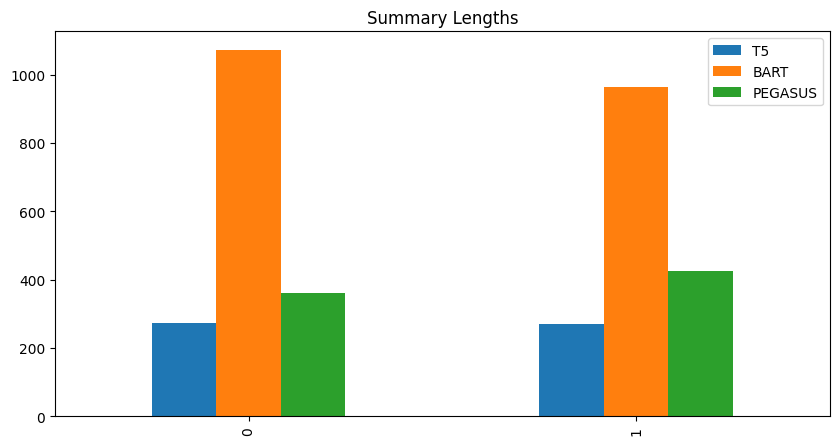

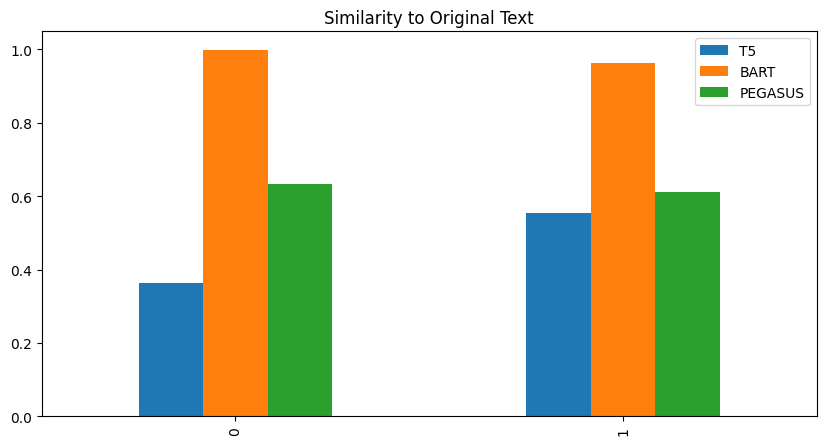

In [112]:
#Enhanced Summarization Comparison
summary_comparison_df = pd.DataFrame({
    'T5_length': t5_lengths,
    'BART_length': bart_lengths,
    'PEGASUS_length': pegasus_lengths,
    'T5_sim': t5_sim,
    'BART_sim': bart_sim,
    'PEGASUS_sim': pegasus_sim
})
print(summary_comparison_df)
import matplotlib.pyplot as plt

# Summary length comparison
length_df.plot(kind='bar', figsize=(10,5), title="Summary Lengths")
plt.show()

# Similarity comparison
sim_df.plot(kind='bar', figsize=(10,5), title="Similarity to Original Text")
plt.show()



**STEP 8.2**: Enhanced Paraphrasing Metrics Plot

   T5_paraphrase_len  BART_paraphrase_len  PEGASUS_paraphrase_len  \
0                725                 4057                     247   
1                821                 3204                      91   

   T5_paraphrase_sim  BART_paraphrase_sim  PEGASUS_paraphrase_sim  
0           0.736641             0.730177                0.247895  
1           0.794357             0.634907                0.279839  


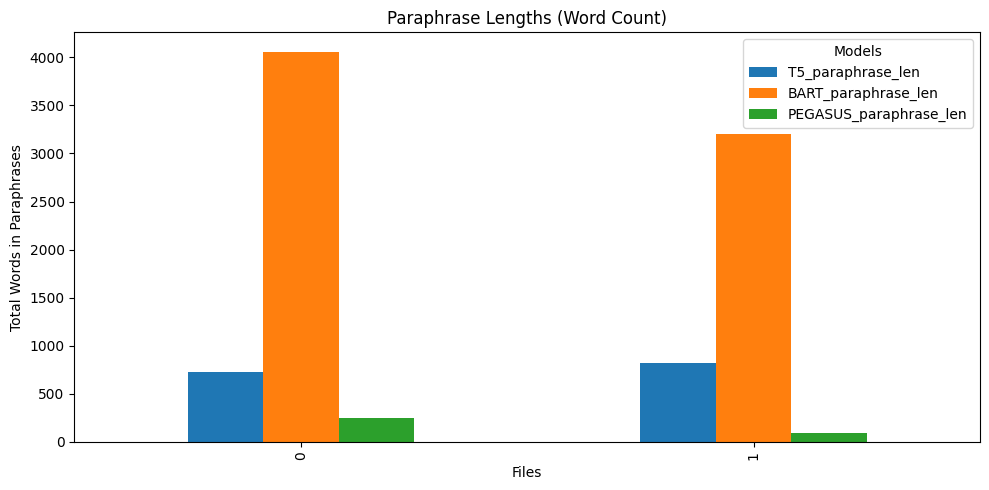

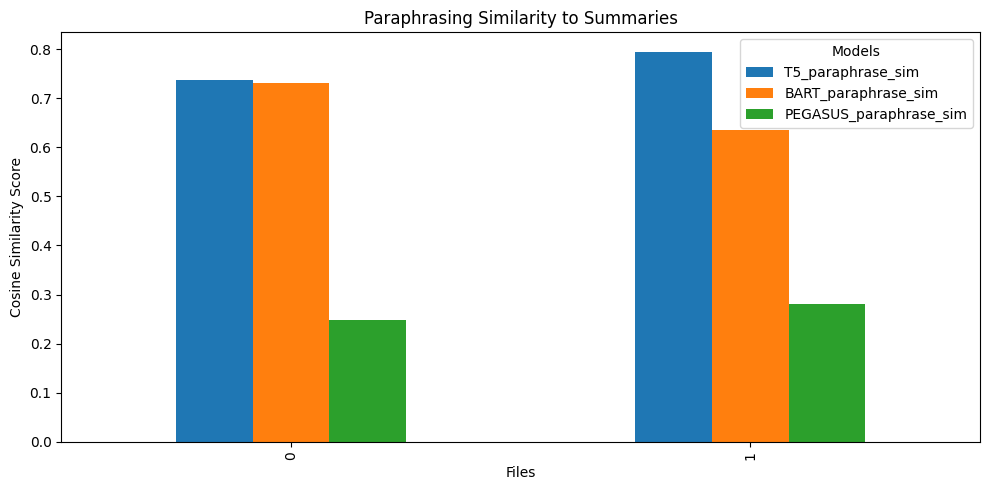

In [114]:
# Compute paraphrasing similarity
# Make sure paraphrases lists exist: t5_paraphrases, bart_paraphrases, pegasus_paraphrases

import pandas as pd
import matplotlib.pyplot as plt

# Compute paraphrase lengths
t5_para_lengths = [len(" ".join(p)) if p else 0 for p in t5_paraphrases]
bart_para_lengths = [len(" ".join(p)) if p else 0 for p in bart_paraphrases]
pegasus_para_lengths = [len(" ".join(p)) if p else 0 for p in pegasus_paraphrases]

# Combine similarity and length in a DataFrame
paraphrase_summary_df = pd.DataFrame({
    'T5_paraphrase_len': t5_para_lengths,
    'BART_paraphrase_len': bart_para_lengths,
    'PEGASUS_paraphrase_len': pegasus_para_lengths,
    'T5_paraphrase_sim': t5_para_sim,
    'BART_paraphrase_sim': bart_para_sim,
    'PEGASUS_paraphrase_sim': pegasus_para_sim
}, index=['0', '1'])

print(paraphrase_summary_df)


# Plot paraphrase lengths first
para_len_df = paraphrase_summary_df[['T5_paraphrase_len', 'BART_paraphrase_len', 'PEGASUS_paraphrase_len']]
para_len_df.plot(kind='bar', figsize=(10,5), title="Paraphrase Lengths (Word Count)")
plt.ylabel("Total Words in Paraphrases")
plt.xlabel("Files")
plt.legend(title="Models")
plt.tight_layout()
plt.show()

# Plot paraphrase similarity next
para_sim_df = paraphrase_summary_df[['T5_paraphrase_sim', 'BART_paraphrase_sim', 'PEGASUS_paraphrase_sim']]
para_sim_df.plot(kind='bar', figsize=(10,5), title="Paraphrasing Similarity to Summaries")
plt.ylabel("Cosine Similarity Score")
plt.xlabel("Files")
plt.legend(title="Models")
plt.tight_layout()
plt.show()



